<a href="https://colab.research.google.com/github/Sarah-0405/Bachelorarbeit_/blob/main/OSMnx_accessibilities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install osmnx
!pip install mapclassify
!pip install geopy
!pip install alphashape

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.1 MB/s eta 0:00:00


In [6]:
from google.colab import drive
drive.mount('/content/drive')

import geopandas as gpd
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import mapclassify
import folium
import matplotlib
import geopy.distance
import numpy as np
from shapely.geometry import Point, MultiPoint
from shapely.ops import unary_union
import geemap
import geopandas as gpd
import shapely.wkt
from alphashape import alphashape
from shapely.geometry import shape, Polygon, MultiPolygon, GeometryCollection, MultiPoint, Point

Mounted at /content/drive


In [36]:
import ee
ee.Authenticate()
ee.Initialize(project="ee-sarahheinz0405")

# Straßennetzwerke direkt über Stadtname laden

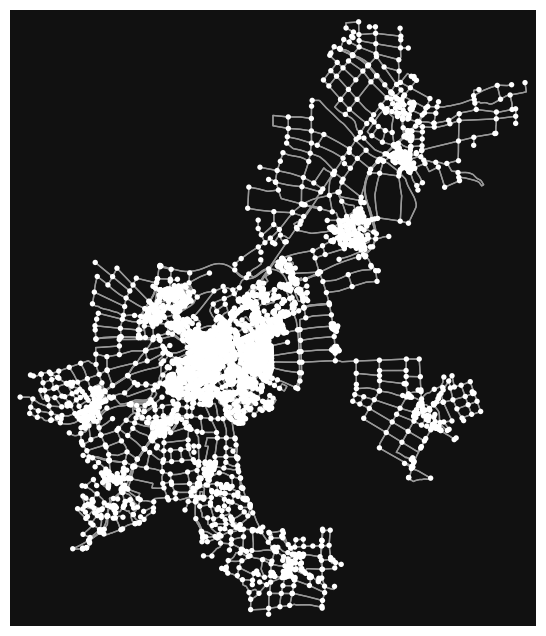

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [30]:
G_Noerdlingen = ox.graph_from_place('Noerdlingen, Germany', network_type='walk')
ox.plot_graph(G_Noerdlingen)

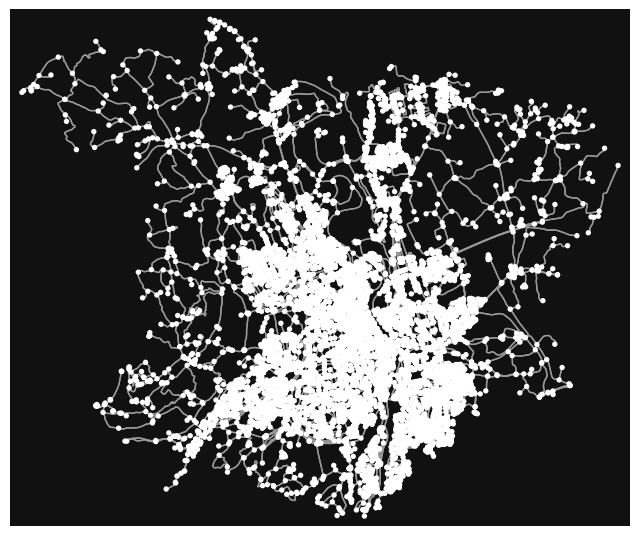

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
G_Kempten = ox.graph_from_place('Kempten, Germany', network_type='walk')
ox.plot_graph(G_Kempten)

In [ ]:
G_Ingolstadt = ox.graph_from_place('Ingolstadt, Germany', network_type='walk')
#ox.plot_graph(G_Ingolstadt)

In [ ]:
# Speichern der Netzwerke im GraphML-Format
ox.save_graphml(G_Noerdlingen, filepath='noerdlingen_strassennetz.graphml')
ox.save_graphml(G_Kempten, filepath='kempten_strassennetz.graphml')
ox.save_graphml(G_Ingolstadt, filepath='ingolstadt_strassennetz.graphml')

Cold-Spots Polygone laden

In [32]:
# Cold Spots aus einer Datei laden (Beispiel: GeoJSON)
cold_spot_Ingolstadt = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Ingolstadt_ColdSpots_Polygon.geojson")
cold_spot_Kempten = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Kempten_ColdSpots_Polygon.geojson")
cold_spot_Noerdlingen = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Noerdlingen_ColdSpots_Polygon.geojson")


nearest nodes: Zentroid Methode nicht so sinnvoll, bringt ungenaues Ergebnis bei unsymmetrischen, langgestreckten Cold Spots

deshalb: Linienbasierte Erreichbarkeitsanalyse mit Grenze der Polygone als Ausgangslinie

# Nördlingen Service Areas

In [ ]:
cold_spot_Noerdlingen = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Noerdlingen_ColdSpots_Polygon.geojson")

# Explodiere MultiPolygone in einzelne Polygone und setze den Index neu
cold_spot_Noerdlingen_exploded = cold_spot_Noerdlingen.explode(index_parts=True).reset_index(drop=True)

print(cold_spot_Noerdlingen_exploded)

                       geometry
0     POINT (10.44089 48.80938)
1     POINT (10.44116 48.80668)
2     POINT (10.44116 48.80695)
3     POINT (10.44116 48.80722)
4     POINT (10.44116 48.80857)
...                         ...
1381  POINT (10.55812 48.82447)
1382  POINT (10.55839 48.82393)
1383   POINT (10.55839 48.8242)
1384  POINT (10.55839 48.82447)
1385   POINT (10.55866 48.8242)

[1386 rows x 1 columns]


überlappende Polygone sollen als ein feature gesehen werden, und alleinstehende ebenso als eines: dafür: nach überlappungen suchen, diese dann zusammenführen und schließlich jedem Cold Spot eine Clsuter ID hinzufügen (um überlappende als Gruppe zu sehen), um schließlich die geometrien zu vereinigen

dafür vorher noch: POINTS (Cold Spots) in Polygone umwandeln => mit buffer Befehl (100m, weil Landsat Pixel auch 100m Auflösung haben)

In [ ]:
# Kopie der Cold Spots-Daten
gdf = cold_spot_Noerdlingen.copy().reset_index(drop=True)

# Geometrien umwandeln
gdf = gdf.to_crs(epsg=32632)

# Prüfen, ob es sich um Punkte oder MultiPoints handelt und diese in Polygone umwandeln
if gdf.geometry.iloc[0].geom_type in ['Point', 'MultiPoint']:
    # Wähle eine Buffer-Distanz (z.B. 20 Meter statt 50, falls 50 zu groß ist)
    buffer_distance = 100     #100m, weil Landsat Band 10 Pixel Auflösung von 100x100m haben
    print(f"Anwenden eines Buffers von {buffer_distance} Metern auf Punktgeometrien.")
    gdf['geometry'] = gdf.geometry.buffer(buffer_distance)

# Optional: Falls du MultiPolygone hast, die noch zusammengehören, explodiere sie
gdf = gdf.explode(index_parts=True).reset_index(drop=True)

# --- Aufbau des Graphen zur Cluster-Bildung ---
G = nx.Graph()
for idx in gdf.index:
    G.add_node(idx)

sindex = gdf.sindex
for idx, geom in gdf.geometry.items():
    possible_matches_index = list(sindex.intersection(geom.bounds))
    for other_idx in possible_matches_index:
        if idx < other_idx:
            # Hier wird überprüft, ob sich die Polygone überschneiden
            if geom.intersects(gdf.loc[other_idx, 'geometry']):
                G.add_edge(idx, other_idx)

clusters = list(nx.connected_components(G))
print("Gefundene Cluster:", clusters)

# Mapping: Jeder ursprüngliche Index erhält eine Cluster-ID
cluster_mapping = {}
for cluster_id, component in enumerate(clusters):
    for idx in component:
        cluster_mapping[idx] = cluster_id

gdf['cluster_id'] = gdf.index.map(cluster_mapping)

# Dissolve: Nur innerhalb desselben Clusters zusammenführen
dissolved_Noerdlingen = gdf.dissolve(by='cluster_id', as_index=False)

print("Dissolved Ergebnisse:")
print(dissolved_Noerdlingen)

# Speichern oder weiterverwenden
# dissolved.to_file("dissolved_Noerdlingen.geojson", driver="GeoJSON")


Anwenden eines Buffers von 100 Metern auf Punktgeometrien.
Gefundene Cluster: [{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16}, {17}, {18}, {19}, {20}, {21}, {22}]
Dissolved Ergebnisse:
    cluster_id                                           geometry
0            0  POLYGON ((614206.043 5409065.481, 614204.968 5...
1            1  POLYGON ((613676.406 5414658.81, 613675.332 54...
2            2  POLYGON ((613563.852 5411449.87, 613562.78 541...
3            3  POLYGON ((613164.47 5414558.491, 613163.398 54...
4            4  POLYGON ((613398.262 5411321.237, 613400.338 5...
5            5  POLYGON ((613378.214 5411331.706, 613376.138 5...
6            6  POLYGON ((613179.681 5413809.583, 613178.609 5...
7            7  POLYGON ((612779.115 5417967.112, 612778.043 5...
8            8  POLYGON ((612482.288 5412602.22, 612480.229 54...
9            9  POLYGON ((611518.41 5411858.152, 611517.342 54...
10          10  POLYGON ((611156.58 5412150.6

In [ ]:
# Projiziere den Graphen in UTM Zone 32N (Beispiel) => metrisches CRS, um Distanzen in Metern zu berechnen!
G_Noerdlingen_proj = ox.project_graph(G_Noerdlingen, to_crs='epsg:32632')

# Überprüfe das neue CRS
print(G_Noerdlingen_proj.graph['crs'])

epsg:32632


ausgehend von den bereits gruppierten Cold Spots (dissolved_Noerdlingen) für jeden Cold Spot eine linienbasierte Erreichbarkeitsanalyse durchführen: entlang der Grenzen der Cold Spots in regelmäßigen Abständen (50 m) eine Reihe von Ausgangspunkten generieren

 Für jeden dieser Punkte wird der nächstgelegene Knoten im Fußgängernetzwerk (G_Noerdlingen) bestimmt. Anschließend wird für jeden dieser Startknoten eine Isochrone (Erreichbarkeitszone) für 5, 10 und 15 Minuten berechnet – bei einer Gehgeschwindigkeit von 1 m/s entspricht das 300, 600 bzw. 900 m. Zum Schluss werden für jeden Cold Spot die Isochronen der einzelnen Startpunkte pro Zeitlimit vereinigt.

In [ ]:
# -----------------------------
# 1) Vorbereitungen
# -----------------------------

# travel time anlegen:
# Bei Gehgeschwindigkeit 1 m/s = 1 Sekunde pro Meter => travel_time = length
for u, v, data in G_Noerdlingen.edges(data=True):
    if 'length' in data:
        data['travel_time'] = data['length']  # 1 m/s => 1 Sekunde pro Meter
    else:
        # Falls keine 'length' vorhanden ist, muss man sie berechnen oder aus OSMnx neu beziehen
        pass

# Prüfe, ob dissolved_Noerdlingen wirklich Polygone enthält:
# (Bei Punkten oder MultiPoints müsste man einen Buffer erstellen oder ähnliche Maßnahmen treffen)
assert all(dissolved_Noerdlingen.geometry.type.isin(['Polygon','MultiPolygon'])), \
    "dissolved_Noerdlingen muss Polygone enthalten!"

# -----------------------------
# 2) Hilfsfunktion: Punkte an Polygonrändern erzeugen
# -----------------------------

def sample_line(line, interval):
    """
    Erzeugt Punkte entlang einer LineString-/MultiLineString-Geometrie
    in regelmäßigen Abständen (interval, z. B. 20 m).
    """
    points = []
    if line.geom_type == "LineString":
        length = line.length
        distances = np.arange(0, length, interval)
        # Endpunkt hinzufügen, falls noch nicht enthalten
        if distances.size == 0 or distances[-1] != length:
            distances = np.append(distances, length)
        for dist in distances:
            points.append(line.interpolate(dist))
    elif line.geom_type == "MultiLineString":
        for part in line:
            length = part.length
            distances = np.arange(0, length, interval)
            if distances.size == 0 or distances[-1] != length:
                distances = np.append(distances, length)
            for dist in distances:
                points.append(part.interpolate(dist))
    return points

# -----------------------------
# 3) Service Area Funktion
# -----------------------------

def compute_service_area(G, start_node, time_cutoff):
    """
    Berechnet die Service Area (als Konvexhülle) aller Knoten, die vom start_node
    aus innerhalb von 'time_cutoff' Sekunden erreichbar sind.
    """
    # Ego-Graph mit radius=time_cutoff und distance='travel_time'
    subgraph = nx.ego_graph(G, start_node, radius=time_cutoff, distance='travel_time')

    # Sammle die Knoten-Geometrien
    node_points = []
    for node, data in G.nodes(data=True):
        if node in subgraph.nodes():
            x, y = data['x'], data['y']
            node_points.append(Point(x, y))

    if node_points:
        mp = MultiPoint(node_points)
        return mp.convex_hull  # Konvexhülle
        # Wenn du eine concave hull (alpha shape) möchtest, siehe Hinweise unten
    else:
        return None

# -----------------------------
# 4) Parameter und Iteration
# -----------------------------

time_thresholds = {
    "service_5min": 300,   # 5 min = 300 s
    "service_10min": 600,  # 10 min = 600 s
    "service_15min": 900   # 15 min = 900 s
}

sample_interval = 10  # Abstand der Punkte an den Polygonrändern in Metern

results = []

for idx, row in dissolved_Noerdlingen.iterrows():
    geom = row.geometry
    boundary = geom.boundary

    # 4.1 Erzeuge Abtastpunkte an der Polygon-Grenze
    boundary_points = sample_line(boundary, sample_interval)

    # 4.2 Finde nächstgelegenen Graph-Knoten für jeden Punkt
    nearest_nodes = set()
    for pt in boundary_points:
        try:
            node = ox.distance.nearest_nodes(G_Noerdlingen, pt.x, pt.y)
            nearest_nodes.add(node)
        except Exception as e:
            print(f"Fehler bei nearest_nodes für Punkt {pt}: {e}")

    # 4.3 Für jeden Zeit-Cutoff berechnen wir eine Union der Service Areas aller Startknoten
    service_polys = { key: [] for key in time_thresholds.keys() }

    for node in nearest_nodes:
        for label, cutoff in time_thresholds.items():
            poly = compute_service_area(G_Noerdlingen, node, cutoff)
            if poly is not None:
                service_polys[label].append(poly)

    # 4.4 Union pro Zeitlimit
    union_dict = {}
    for label, polys in service_polys.items():
        if polys:
            union_dict[label] = unary_union(polys)
        else:
            union_dict[label] = None

    # Speichere das Ergebnis in einer Liste
    results.append({
        'cold_spot_id': idx,
        'geometry': geom,  # Die Originalgeometrie (Cold Spot)
        'service_5min': union_dict["service_5min"],
        'service_10min': union_dict["service_10min"],
        'service_15min': union_dict["service_15min"]
    })

# -----------------------------
# 5) GeoDataFrame erstellen
# -----------------------------
service_area_gdf = gpd.GeoDataFrame(results, crs=dissolved_Noerdlingen.crs)

# Beispiel-Ausgabe
print(service_area_gdf)

# Optional: Abspeichern
#service_area_gdf.to_csv("service_area_gdf_Noerdlingen.csv", index=False)


    cold_spot_id                                           geometry  \
0              0  POLYGON ((614206.043 5409065.481, 614204.968 5...   
1              1  POLYGON ((613676.406 5414658.81, 613675.332 54...   
2              2  POLYGON ((613563.852 5411449.87, 613562.78 541...   
3              3  POLYGON ((613164.47 5414558.491, 613163.398 54...   
4              4  POLYGON ((613398.262 5411321.237, 613400.338 5...   
5              5  POLYGON ((613378.214 5411331.706, 613376.138 5...   
6              6  POLYGON ((613179.681 5413809.583, 613178.609 5...   
7              7  POLYGON ((612779.115 5417967.112, 612778.043 5...   
8              8  POLYGON ((612482.288 5412602.22, 612480.229 54...   
9              9  POLYGON ((611518.41 5411858.152, 611517.342 54...   
10            10  POLYGON ((611156.58 5412150.615, 611155.514 54...   
11            11  POLYGON ((610329.607 5405960.828, 610328.544 5...   
12            12  POLYGON ((609613.175 5413198.93, 609612.112 54...   
13    

Service areas visualisieren

In [ ]:
import ee
ee.Authenticate()
ee.Initialize(project="ee-sarahheinz0405")

In [ ]:
# --- Annahme: dissolved_Noerdlingen und service_area_gdf sind bereits geladen ---
# Beide GeoDataFrames sollten Flächen (Polygone) enthalten.

# Stelle sicher, dass beide Datensätze in EPSG:4326 vorliegen (für geemap/Leaflet)
dissolved_Noerdlingen = dissolved_Noerdlingen.to_crs(epsg=4326)
service_area_gdf = service_area_gdf.to_crs(epsg=4326)

# Bestimme das Karten-Zentrum anhand der gesamten dissolved_Noerdlingen-Geometrie
center = dissolved_Noerdlingen.unary_union.centroid
center_lat = center.y
center_lon = center.x

# Erstelle eine geemap-Karte
Map = geemap.Map(center=[center_lat, center_lon], zoom=13)

# Optional: Zeige die dissolved Cold Spots als Umriss (z.B. in blau)
Map.add_gdf(
    dissolved_Noerdlingen,
    layer_name="Cold Spots",
    style={"color": "blue", "fillColor": "blue", "weight": 2},
)

# Erstelle für jede Isochronen-Kategorie ein eigenes GeoDataFrame
gdf_5min = service_area_gdf.dropna(subset=["service_5min"]).copy()
gdf_5min = gpd.GeoDataFrame(geometry=gdf_5min["service_5min"], crs=service_area_gdf.crs)

gdf_10min = service_area_gdf.dropna(subset=["service_10min"]).copy()
gdf_10min = gpd.GeoDataFrame(geometry=gdf_10min["service_10min"], crs=service_area_gdf.crs)

gdf_15min = service_area_gdf.dropna(subset=["service_15min"]).copy()
gdf_15min = gpd.GeoDataFrame(geometry=gdf_15min["service_15min"], crs=service_area_gdf.crs)

# Füge die 5min-Isochrone als Layer (hellgrün) hinzu
Map.add_gdf(
    gdf_5min,
    layer_name="5min Service Area",
    style={"color": "#90EE90", "fillColor": "#90EE90", "fillOpacity": 0.3, "weight": 2},
)

# Füge die 10min-Isochrone als Layer (grün) hinzu
Map.add_gdf(
    gdf_10min,
    layer_name="10min Service Area",
    style={"color": "green", "fillColor": "green", "fillOpacity": 0.3, "weight": 2},
)

# Füge die 15min-Isochrone als Layer (dunkelgrün) hinzu
Map.add_gdf(
    gdf_15min,
    layer_name="15min Service Area",
    style={"color": "#006400", "fillColor": "#006400", "fillOpacity": 0.3, "weight": 2},
)

# Füge eine LayerControl hinzu, um die einzelnen Layer ein- oder auszuschalten
Map.add_layer_control()

# Zeige die Karte (z.B. in einem Jupyter Notebook) oder speichere sie als HTML-Datei
Map.save("Service_Areas_ColdSpots_Noerdlingen.html")
Map

Map(center=[48.841360886265036, 10.499021647257061], controls=(WidgetControl(options=['position', 'transparent…

Punktmarkierungen auf der Karte, weil bei 5 Minuten teilweise nur ein Knotenpunkt des OSM Fußwegenetzes erreichbar ist, und daraus keine Fläche generiert werden kann.

In [35]:
Karte = "/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /Service_Areas_ColdSpots_Noerdlingen.html"

Map

'/content/Service_Areas_ColdSpots_Noerdlingen.html'

# gleiches für Kempten und Ingolstadt

In [41]:
# --- Funktionen ---

def sample_line(line, interval):
    """
    Erzeugt Punkte entlang einer LineString-/MultiLineString-Geometrie
    in regelmäßigen Abständen (interval, z. B. 20 m).
    """
    points = []
    if line.geom_type == "LineString":
        length = line.length
        distances = np.arange(0, length, interval)
        # Endpunkt hinzufügen, falls noch nicht enthalten
        if distances.size == 0 or distances[-1] != length:
            distances = np.append(distances, length)
        for dist in distances:
            points.append(line.interpolate(dist))
    elif line.geom_type == "MultiLineString":
        # Iterate over the individual LineStrings within the MultiLineString
        for part in line.geoms:  # changed line: Iterate over line.geoms
            length = part.length
            distances = np.arange(0, length, interval)
            if distances.size == 0 or distances[-1] != length:
                distances = np.append(distances, length)
            for dist in distances:
                points.append(part.interpolate(dist))
    return points


def compute_service_area(G, start_node, time_cutoff):
    """Berechnet die Service Area (als Konvexhülle) aller erreichbaren Knoten."""
    subgraph = nx.ego_graph(G, start_node, radius=time_cutoff, distance='travel_time')
    node_points = []
    for node, data in G.nodes(data=True):
        if node in subgraph.nodes():
            x, y = data['x'], data['y']
            node_points.append(Point(x, y))
    if node_points:
        mp = MultiPoint(node_points)
        return mp.convex_hull
    else:
        return None


# --- Hauptteil ---

# --- Schleife über die Städte ---
for stadt, graph, cold_spot_data in [
    ("Noerdlingen", G_Noerdlingen, cold_spot_Noerdlingen),
    ("Kempten", G_Kempten, cold_spot_Kempten),
    ("Ingolstadt", G_Ingolstadt, cold_spot_Ingolstadt)
]:
    print(f"--- Verarbeitung von {stadt} ---")

    # Vorbereitungen: 'travel_time' hinzufügen
    for u, v, data in graph.edges(data=True):
        if 'length' in data:
            data['travel_time'] = data['length']

    # Buffer auf Cold Spots anwenden (falls nötig)
    gdf = cold_spot_data.copy().reset_index(drop=True)
    gdf = gdf.to_crs(epsg=32632)
    if gdf.geometry.iloc[0].geom_type in ['Point', 'MultiPoint']:
        buffer_distance = 100
        print(f"Anwenden eines Buffers von {buffer_distance} Metern auf Punktgeometrien.")
        gdf['geometry'] = gdf.geometry.buffer(buffer_distance)
    gdf = gdf.explode(index_parts=True).reset_index(drop=True)

    # --- Clusterbildung und Dissolven ---
    G = nx.Graph()
    for idx in gdf.index:
        G.add_node(idx)

    sindex = gdf.sindex
    for idx, geom in gdf.geometry.items():
        possible_matches_index = list(sindex.intersection(geom.bounds))
        for other_idx in possible_matches_index:
            if idx < other_idx:
                if geom.intersects(gdf.loc[other_idx, 'geometry']):
                    G.add_edge(idx, other_idx)

    clusters = list(nx.connected_components(G))
    cluster_mapping = {}
    for cluster_id, component in enumerate(clusters):
        for idx in component:
            cluster_mapping[idx] = cluster_id

    gdf['cluster_id'] = gdf.index.map(cluster_mapping)
    dissolved_gdf = gdf.dissolve(by='cluster_id', as_index=False)


    # --- Service Area Berechnung ---
    time_thresholds = {"service_5min": 300, "service_10min": 600, "service_15min": 900}
    sample_interval = 10
    results = []

    for idx, row in dissolved_gdf.iterrows():  # Hier dissolved_gdf verwenden
        geom = row.geometry
        boundary = geom.boundary
        boundary_points = sample_line(boundary, sample_interval)
        nearest_nodes = set()
        for pt in boundary_points:
            try:
                node = ox.distance.nearest_nodes(graph, pt.x, pt.y)
                nearest_nodes.add(node)
            except Exception as e:
                print(f"Fehler bei nearest_nodes für Punkt {pt}: {e}")
        service_polys = {key: [] for key in time_thresholds.keys()}
        for node in nearest_nodes:
            for label, cutoff in time_thresholds.items():
                poly = compute_service_area(graph, node, cutoff)
                if poly is not None:
                    service_polys[label].append(poly)
        union_dict = {}
        for label, polys in service_polys.items():
            if polys:
                union_dict[label] = unary_union(polys)
            else:
                union_dict[label] = None
        results.append({
            'cold_spot_id': idx,
            'geometry': geom,
            'service_5min': union_dict["service_5min"],
            'service_10min': union_dict["service_10min"],
            'service_15min': union_dict["service_15min"]
        })

    # GeoDataFrame erstellen und speichern
    service_area_gdf = gpd.GeoDataFrame(results, crs=dissolved_gdf.crs)
    service_area_gdf.to_csv(f"service_area_gdf_{stadt}.csv", index=False)
    service_area_gdf.to_file(f"service_area_gdf_{stadt}.geojson", driver="GeoJSON")

    print(f"--- {stadt} abgeschlossen ---")



--- Verarbeitung von Noerdlingen ---
Anwenden eines Buffers von 100 Metern auf Punktgeometrien.
--- Noerdlingen abgeschlossen ---
--- Verarbeitung von Kempten ---
Anwenden eines Buffers von 100 Metern auf Punktgeometrien.
--- Kempten abgeschlossen ---
--- Verarbeitung von Ingolstadt ---
Anwenden eines Buffers von 100 Metern auf Punktgeometrien.
--- Ingolstadt abgeschlossen ---


mit debugging extra:

Problem: debugging hat gezeigt, dass Anzahl der erreichbaren Knotenpunkte mit Erhöhung der Travel Time ansteigt => eigentlich müsste service_area_15min > 10min > 5 min sein, was die Anzahl der Punkte enthält. manchmal enthält Geometrycollection von 10 minuten aber nur einen Punkt, während bei 5 Minuten mehrere Punkte erreichbar sind.

In [33]:
# --- Funktionen ---

def sample_line(line, interval):
    """
    Erzeugt Punkte entlang einer LineString-/MultiLineString-Geometrie
    in regelmäßigen Abständen (interval, z. B. 20 m).
    """
    points = []
    if line.geom_type == "LineString":
        length = line.length
        distances = np.arange(0, length, interval)
        # Endpunkt hinzufügen, falls noch nicht enthalten
        if distances.size == 0 or distances[-1] != length:
            distances = np.append(distances, length)
        for dist in distances:
            points.append(line.interpolate(dist))
    elif line.geom_type == "MultiLineString":
        # Iterate over the individual LineStrings within the MultiLineString
        for part in line.geoms:  # changed line: Iterate over line.geoms
            length = part.length
            distances = np.arange(0, length, interval)
            if distances.size == 0 or distances[-1] != length:
                distances = np.append(distances, length)
            for dist in distances:
                points.append(part.interpolate(dist))
    return points


def compute_service_area(G, start_node, time_cutoff):
    """Berechnet die Service Area (als Konvexhülle) aller erreichbaren Knoten."""
    subgraph = nx.ego_graph(G, start_node, radius=time_cutoff, distance='travel_time')

    # **Debugging Print**
    print(f"Reachable nodes for {time_cutoff} seconds: {len(subgraph.nodes())}")

    node_points = []
    for node, data in G.nodes(data=True):
        if node in subgraph.nodes():
            x, y = data['x'], data['y']
            node_points.append(Point(x, y))
    if node_points:
        mp = MultiPoint(node_points)
        return mp.convex_hull
    else:
        return None


# --- Hauptteil ---

# --- Schleife über die Städte ---
for stadt, graph, cold_spot_data in [
    ("Noerdlingen", G_Noerdlingen, cold_spot_Noerdlingen),

]:
    print(f"--- Verarbeitung von {stadt} ---")

    # Vorbereitungen: 'travel_time' hinzufügen
    for u, v, data in graph.edges(data=True):
        if 'length' in data:
            data['travel_time'] = data['length']

    # Buffer auf Cold Spots anwenden (falls nötig)
    gdf = cold_spot_data.copy().reset_index(drop=True)
    gdf = gdf.to_crs(epsg=32632)
    if gdf.geometry.iloc[0].geom_type in ['Point', 'MultiPoint']:
        buffer_distance = 100
        print(f"Anwenden eines Buffers von {buffer_distance} Metern auf Punktgeometrien.")
        gdf['geometry'] = gdf.geometry.buffer(buffer_distance)
    gdf = gdf.explode(index_parts=True).reset_index(drop=True)

    # --- Clusterbildung und Dissolven ---
    G = nx.Graph()
    for idx in gdf.index:
        G.add_node(idx)

    sindex = gdf.sindex
    for idx, geom in gdf.geometry.items():
        possible_matches_index = list(sindex.intersection(geom.bounds))
        for other_idx in possible_matches_index:
            if idx < other_idx:
                if geom.intersects(gdf.loc[other_idx, 'geometry']):
                    G.add_edge(idx, other_idx)

    clusters = list(nx.connected_components(G))
    cluster_mapping = {}
    for cluster_id, component in enumerate(clusters):
        for idx in component:
            cluster_mapping[idx] = cluster_id

    gdf['cluster_id'] = gdf.index.map(cluster_mapping)
    dissolved_gdf = gdf.dissolve(by='cluster_id', as_index=False)


    # --- Service Area Berechnung ---
    time_thresholds = {"service_5min": 300, "service_10min": 600, "service_15min": 900}
    sample_interval = 10
    results = []

    for idx, row in dissolved_gdf.iterrows():  # Hier dissolved_gdf verwenden
        geom = row.geometry
        boundary = geom.boundary
        boundary_points = sample_line(boundary, sample_interval)
        nearest_nodes = set()
        for pt in boundary_points:
            try:
                node = ox.distance.nearest_nodes(graph, pt.x, pt.y)
                nearest_nodes.add(node)
            except Exception as e:
                print(f"Fehler bei nearest_nodes für Punkt {pt}: {e}")
        service_polys = {key: [] for key in time_thresholds.keys()}
        for node in nearest_nodes:
            for label, cutoff in time_thresholds.items():
                poly = compute_service_area(graph, node, cutoff)
                if poly is not None:
                    service_polys[label].append(poly)
        union_dict = {}
        for label, polys in service_polys.items():
            if polys:
                union_dict[label] = unary_union(polys)
            else:
                union_dict[label] = None
        results.append({
            'cold_spot_id': idx,
            'geometry': geom,
            'service_5min': union_dict["service_5min"],
            'service_10min': union_dict["service_10min"],
            'service_15min': union_dict["service_15min"]
        })

    # GeoDataFrame erstellen und speichern
    service_area_gdf = gpd.GeoDataFrame(results, crs=dissolved_gdf.crs)
    service_area_gdf.to_csv(f"service_area_gdf_{stadt}.csv", index=False)
    service_area_gdf.to_file(f"service_area_gdf_{stadt}.geojson", driver="GeoJSON")

    print(f"--- {stadt} abgeschlossen ---")



--- Verarbeitung von Noerdlingen ---
Anwenden eines Buffers von 100 Metern auf Punktgeometrien.
Reachable nodes for 300 seconds: 1
Reachable nodes for 600 seconds: 7
Reachable nodes for 900 seconds: 17
Reachable nodes for 300 seconds: 2
Reachable nodes for 600 seconds: 8
Reachable nodes for 900 seconds: 18
Reachable nodes for 300 seconds: 1
Reachable nodes for 600 seconds: 2
Reachable nodes for 900 seconds: 4
Reachable nodes for 300 seconds: 1
Reachable nodes for 600 seconds: 3
Reachable nodes for 900 seconds: 8
Reachable nodes for 300 seconds: 2
Reachable nodes for 600 seconds: 5
Reachable nodes for 900 seconds: 10
Reachable nodes for 300 seconds: 1
Reachable nodes for 600 seconds: 7
Reachable nodes for 900 seconds: 12
Reachable nodes for 300 seconds: 2
Reachable nodes for 600 seconds: 6
Reachable nodes for 900 seconds: 11
Reachable nodes for 300 seconds: 3
Reachable nodes for 600 seconds: 9
Reachable nodes for 900 seconds: 12
Reachable nodes for 300 seconds: 3
Reachable nodes for 600

In [60]:
# GeoJSON-Dateien laden
noerdlingen = gpd.read_file('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /service_area_gdf_Noerdlingen.geojson')
kempten = gpd.read_file('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /service_area_gdf_Kempten.geojson')
ingolstadt = gpd.read_file('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /service_area_gdf_Ingolstadt.geojson')

# Informationen extrahieren und in DataFrames speichern
noerdlingen_info = pd.DataFrame(noerdlingen)
kempten_info = pd.DataFrame(kempten)
ingolstadt_info = pd.DataFrame(ingolstadt)

# DataFrames anzeigen
print("Nördlingen:")
print(noerdlingen_info)

print("\nKempten:")
print(kempten_info)

print("\nIngolstadt:")
print(ingolstadt_info)

# Karten-Zentrum bestimmen (z.B. Mittelpunkt von Deutschland)
center = [51.1657, 10.4515]  # Deutschland

# Karte erstellen
Map = geemap.Map(center=center, zoom=6)

# GeoJSON-Daten zur Karte hinzufügen
Map.add_gdf(noerdlingen, layer_name='Nördlingen', style={'color': 'red', 'fillColor': 'red', 'fillOpacity': 0.3})
Map.add_gdf(kempten, layer_name='Kempten', style={'color': 'green', 'fillColor': 'green', 'fillOpacity': 0.3})
Map.add_gdf(ingolstadt, layer_name='Ingolstadt', style={'color': 'blue', 'fillColor': 'blue', 'fillOpacity': 0.3})

# LayerControl hinzufügen, um die einzelnen Layer ein- oder auszuschalten
Map.add_layer_control()

# Karte anzeigen
Map

Nördlingen:
    cold_spot_id                                       service_5min  \
0              0  GEOMETRYCOLLECTION (POINT (10.4281618 48.84131...   
1              1  GEOMETRYCOLLECTION (POINT (10.4281618 48.84131...   
2              2  GEOMETRYCOLLECTION (POINT (10.4281618 48.84131...   
3              3  GEOMETRYCOLLECTION (POINT (10.4281618 48.84131...   
4              4  GEOMETRYCOLLECTION (POINT (10.4281618 48.84131...   
5              5  GEOMETRYCOLLECTION (POINT (10.4281618 48.84131...   
6              6  GEOMETRYCOLLECTION (POINT (10.4281618 48.84131...   
7              7  GEOMETRYCOLLECTION (POINT (10.4281618 48.84131...   
8              8  GEOMETRYCOLLECTION (POINT (10.4281618 48.84131...   
9              9  GEOMETRYCOLLECTION (POINT (10.4281618 48.84131...   
10            10  GEOMETRYCOLLECTION (POINT (10.4281618 48.84131...   
11            11  GEOMETRYCOLLECTION (POINT (10.4281618 48.84131...   
12            12  GEOMETRYCOLLECTION (POINT (10.4281618 48.84131.

Map(center=[51.1657, 10.4515], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

service area spalten enthalten teilweise nur Punkte => daraus Polygone erstellen mit Alpha Shapes oder convex hull

In [62]:
# GeoJSON-Dateien laden
noerdlingen = gpd.read_file('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /service_area_gdf_Noerdlingen.geojson')
kempten = gpd.read_file('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /service_area_gdf_Kempten.geojson')
ingolstadt = gpd.read_file('/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Cold Spots /service_area_gdf_Ingolstadt.geojson')
